<a href="https://colab.research.google.com/github/ZUHAIR-5421342/DS482-DeepLearning-Project/blob/main/DS482_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project Description:
For this project, you will choose an image dataset of your choice. and conduct suitable Deep Learning tools, models, and frameworks. After processing the dataset, you must apply relevant evaluation metrics to analyze the model’s performance and extract meaningful results.


# Data Dictionary and Information

**Dataset:** Pascal Visual Object Classes (VOC) 2007  
**Link:** [http://host.robots.ox.ac.uk/pascal/VOC/](http://host.robots.ox.ac.uk/pascal/VOC/)

## Overview
The Pascal VOC 2007 dataset is a widely used benchmark in the field of computer vision, especially for the tasks of object detection, classification, and segmentation. Developed as part of the Pascal Visual Object Classes Challenge, it contains images annotated with objects from 20 distinct classes along with a background class.

## Key Details

- **Number of Classes:** 20 object classes (plus a background class). The classes include:
  - *aeroplane, bicycle, bird, boat, bottle, bus, car, cat, chair, cow, diningtable, dog, horse, motorbike, person, pottedplant, sheep, sofa, train, tvmonitor*

- **Annotations:**
  - The data come with XML annotations that describe each image.
  - **Annotation Structure:**
    - **`folder`**: The folder name (e.g., "VOC2007").
    - **`filename`**: The image file name.
    - **`source`**: Metadata about the image database and source.
    - **`owner`**: Information about the owner of the image.
    - **`size`**: Dimensions of the image (width, height, depth).
    - **`segmented`**: Indicates whether the image contains segmentation data.
    - **`object`**: Details of each object in the image. *Note:*  
      - When only one object exists, this field is a dictionary;  
      - For multiple objects, it is a list of dictionaries.
      - Each object dictionary includes:
        - **`name`**: The object class label (e.g., "dog").
        - **`pose`**: The pose of the object.
        - **`truncated`**: A flag indicating if the object is truncated.
        - **`difficult`**: A flag that notes if the object is considered difficult to detect.
        - **`bndbox`**: The bounding box coordinates defined by `xmin`, `ymin`, `xmax`, and `ymax`.

## Usage
The dataset is primarily used for:
- **Object Detection:** Training models to both locate and classify objects within images.
- **Image Classification:** Categorizing images by the object they contain.
- **Segmentation:** (When segmentation annotations are used) Delineating object boundaries.

For further details, visit the [VOC Challenge website](http://host.robots.ox.ac.uk/pascal/VOC/).



## Object Detection with Pascal VOC using Faster R-CNN and PyTorch

#### This notebook demonstrates how to fine-tune a pre-trained Faster R-CNN model on the Pascal VOC 2007 dataset.  

### We will cover:
* Data loading and preprocessing
* Model preparation (using transfer learning)
* Training with real-time visualization of the loss
* Evaluation using classification metrics and confusion matrix visualization
* Inference: visualization of predicted bounding boxes on test images

### **Note:** For a full-scale project, increase the number of training epochs and consider more advanced evaluation metrics (e.g., mAP).



## 1. Setup and Import Libraries

In [ ]:
import os
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

# Setup for inline Matplotlib plots
%matplotlib inline

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


## 2. Define Pascal VOC Classes and Their Mappings

### The Pascal VOC dataset consists of 20 object classes along with a background class.

In [ ]:
VOC_CLASSES = [
    'background', 'aeroplane', 'bicycle', 'bird',
    'boat', 'bottle', 'bus', 'car', 'cat', 'chair',
    'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]
VOC_CLASS_TO_IDX = {cls: idx for idx, cls in enumerate(VOC_CLASSES)}

print("VOC Classes:", VOC_CLASSES)
print("VOC Class to Index Mapping:", VOC_CLASS_TO_IDX)

VOC Classes: ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
VOC Class to Index Mapping: {'background': 0, 'aeroplane': 1, 'bicycle': 2, 'bird': 3, 'boat': 4, 'bottle': 5, 'bus': 6, 'car': 7, 'cat': 8, 'chair': 9, 'cow': 10, 'diningtable': 11, 'dog': 12, 'horse': 13, 'motorbike': 14, 'person': 15, 'pottedplant': 16, 'sheep': 17, 'sofa': 18, 'train': 19, 'tvmonitor': 20}


## 3. Data Loading and Preprocessing

### We use `torchvision.datasets.VOCDetection` to load the dataset.  
### The annotations (in XML) are parsed into a Python dictionary, then transformed into the format expected by Faster R-CNN (i.e., a dictionary with `boxes` and `labels`).

In [ ]:
# Define image transformation
transform = transforms.Compose([transforms.ToTensor()])

# Define directories (this downloads the dataset if not already present)
root_dir = './VOCdevkit'

# Load the datasets
train_set = torchvision.datasets.VOCDetection(root=root_dir, year='2007',
                                                image_set='trainval', download=True,
                                                transform=transform)
test_set = torchvision.datasets.VOCDetection(root=root_dir, year='2007',
                                               image_set='test', download=True,
                                               transform=transform)

100%|██████████| 460M/460M [00:23<00:00, 19.8MB/s]
100%|██████████| 451M/451M [00:25<00:00, 17.9MB/s]


In [ ]:
# Collate function to handle batch of images with variable number of objects
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=4,
                                           shuffle=True, num_workers=4,
                                           collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4,
                                          shuffle=False, num_workers=4,
                                          collate_fn=collate_fn)

In [ ]:
# Helper function: Transform VOC XML annotation into a dictionary with 'boxes' and 'labels'
def voc_transform(target):
    ann = target['annotation']
    objs = ann['object'] if isinstance(ann['object'], list) else [ann['object']]
    boxes, labels = [], []
    for obj in objs:
        bbox = obj['bndbox']
        xmin = float(bbox['xmin'])
        ymin = float(bbox['ymin'])
        xmax = float(bbox['xmax'])
        ymax = float(bbox['ymax'])
        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(VOC_CLASS_TO_IDX.get(obj['name'], 0))
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    labels = torch.as_tensor(labels, dtype=torch.int64)
    return {'boxes': boxes, 'labels': labels}

## 4. Model Setup: Modify Faster R-CNN for Pascal VOC

### We load a pre-trained Faster R-CNN model and modify the final prediction layer for 21 classes (background + 20 objects).


In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = len(VOC_CLASSES)  # 21 classes
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model = model.to(device)

# Define optimizer & learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 228MB/s]


## 5. Training Loop with Loss Visualization

### Here we run a short training loop (5 epochs) and store the training loss for visualization.

### **Note:** In a real project, a longer training cycle is recommended.

In [ ]:
num_epochs = 5
train_loss_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        # Transform each target from VOC XML format to the required dictionary format
        targets_transformed = [voc_transform(t) for t in targets]
        targets_transformed = [{k: v.to(device) for k, v in t.items()} for t in targets_transformed]

        loss_dict = model(images, targets_transformed)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        running_loss += losses.item()

    lr_scheduler.step()
    epoch_loss = running_loss / len(train_loader)
    train_loss_history.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Epoch [1/5], Loss: 0.4157
Epoch [2/5], Loss: 0.3082
Epoch [3/5], Loss: 0.2722
Epoch [4/5], Loss: 0.2035
Epoch [5/5], Loss: 0.1874


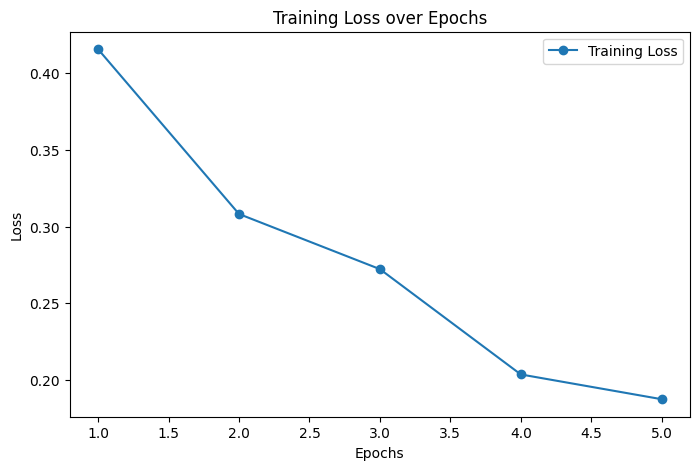

In [ ]:
# Visualize the training loss over epochs
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, num_epochs+1), train_loss_history, marker='o', linestyle='-',
         label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

## 6. Evaluation: Metrics and Confusion Matrix

### We now perform inference on the test set and evaluate the model.  
### For evaluation, we:
* Match predicted boxes to ground truth boxes using a simple IoU-based strategy.
* Accumulate ground truth and predicted class labels.
* Compute and print the confusion matrix, accuracy, precision, recall, and F1 score.

### First, we define functions to compute IoU and match predictions.

In [ ]:
def compute_iou(box1, box2):
    """
    Compute Intersection over Union (IoU) for two boxes. Boxes are expected in [xmin, ymin, xmax, ymax] format.
    """
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area
    if union_area == 0:
        return 0
    return inter_area / union_area

In [ ]:
def match_predictions_to_ground_truth(gt_boxes, gt_labels, pred_boxes, pred_labels, pred_scores, iou_threshold=0.5):
    """
    Greedily match predicted boxes to ground-truth boxes based on IoU.
    Returns a list of (gt_label, pred_label) for matched objects.
    """
    matched_gt = set()
    matches = []
    sorted_idx = np.argsort(pred_scores)[::-1]
    for i in sorted_idx:
        pb = pred_boxes[i]
        highest_iou = 0
        highest_j = -1
        for j, gb in enumerate(gt_boxes):
            if j in matched_gt:
                continue
            iou = compute_iou(pb, gb)
            if iou > highest_iou:
                highest_iou = iou
                highest_j = j
        if highest_iou >= iou_threshold and highest_j != -1:
            matched_gt.add(highest_j)
            matches.append((gt_labels[highest_j], pred_labels[i]))
    return matches

## 6.1 Inference and Metrics Computation

### We loop through the test set, compute predictions and match them against the ground truth. Subsequently, we compute:
* Confusion matrix
* Accuracy, precision, recall, F1 score and a detailed classification report

In [ ]:
all_gt_labels = []
all_pred_labels = []
score_threshold = 0.5  # Only consider predictions above this score

model.eval()
for images, targets in test_loader:
    images = [img.to(device) for img in images]
    targets_transformed = [voc_transform(t) for t in targets]

    with torch.no_grad():
        predictions = model(images)

    for idx, pred in enumerate(predictions):
        gt_data = targets_transformed[idx]
        gt_boxes = gt_data['boxes'].cpu().numpy()
        gt_labels = gt_data['labels'].cpu().numpy()

        pred_boxes = pred['boxes'].cpu().numpy()
        pred_labels = pred['labels'].cpu().numpy()
        pred_scores = pred['scores'].cpu().numpy()

        # Filter predictions by confidence score
        keep = pred_scores >= score_threshold
        pred_boxes = pred_boxes[keep]
        pred_labels = pred_labels[keep]
        pred_scores = pred_scores[keep]

        matches = match_predictions_to_ground_truth(gt_boxes, gt_labels, pred_boxes, pred_labels, pred_scores)
        for m in matches:
            all_gt_labels.append(m[0])
            all_pred_labels.append(m[1])

if all_gt_labels and all_pred_labels:
    cm = confusion_matrix(all_gt_labels, all_pred_labels)
    acc = accuracy_score(all_gt_labels, all_pred_labels)
    prec = precision_score(all_gt_labels, all_pred_labels, average='macro', zero_division=0)
    rec = recall_score(all_gt_labels, all_pred_labels, average='macro', zero_division=0)
    f1_val = f1_score(all_gt_labels, all_pred_labels, average='macro', zero_division=0)
    cr = classification_report(all_gt_labels, all_pred_labels, target_names=VOC_CLASSES[1:])

    print("Confusion Matrix:\n", cm)
    print("\nAccuracy: {:.4f}".format(acc))
    print("Precision: {:.4f}".format(prec))
    print("Recall: {:.4f}".format(rec))
    print("F1 Score: {:.4f}\n".format(f1_val))
    print("Classification Report:\n", cr)
else:
    print("No valid matches found to evaluate metrics.")


Confusion Matrix:
 [[ 264    0    0    2    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [   0  321    0    0    0    0    0    0    0    0    0    0    0    9
     3    0    0    0    0    0]
 [   3    0  422    5    0    0    0    4    0    0    0    5    0    0
     6    0    1    0    0    0]
 [   0    0    0  273    0    1    0    0    1    0    0    0    0    0
     1    0    0    0    3    0]
 [   0    0    1    0  423    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    1]
 [   0    0    0    0    0  205    8    0    0    0    0    0    0    0
     1    0    0    0    1    0]
 [   0    2    0    1    0    5 1332    0    0    0    0    0    0    1
     0    0    0    0    3    0]
 [   0    0    1    0    0    0    0  315    0    0    0   20    0    0
     4    0    0    1    0    0]
 [   1    0    0    0    0    0    0    0  867    0    3    1    0    0
    14    0    0   53    0    0]
 [   0    0    1    0    0    0    0

## 6.2 Visualization: Confusion Matrix

### We use Seaborn to create a heatmap for the confusion matrix.  
### The background class (index 0) is typically excluded from reporting; hence, the heatmap only displays the 20 object classes.

In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

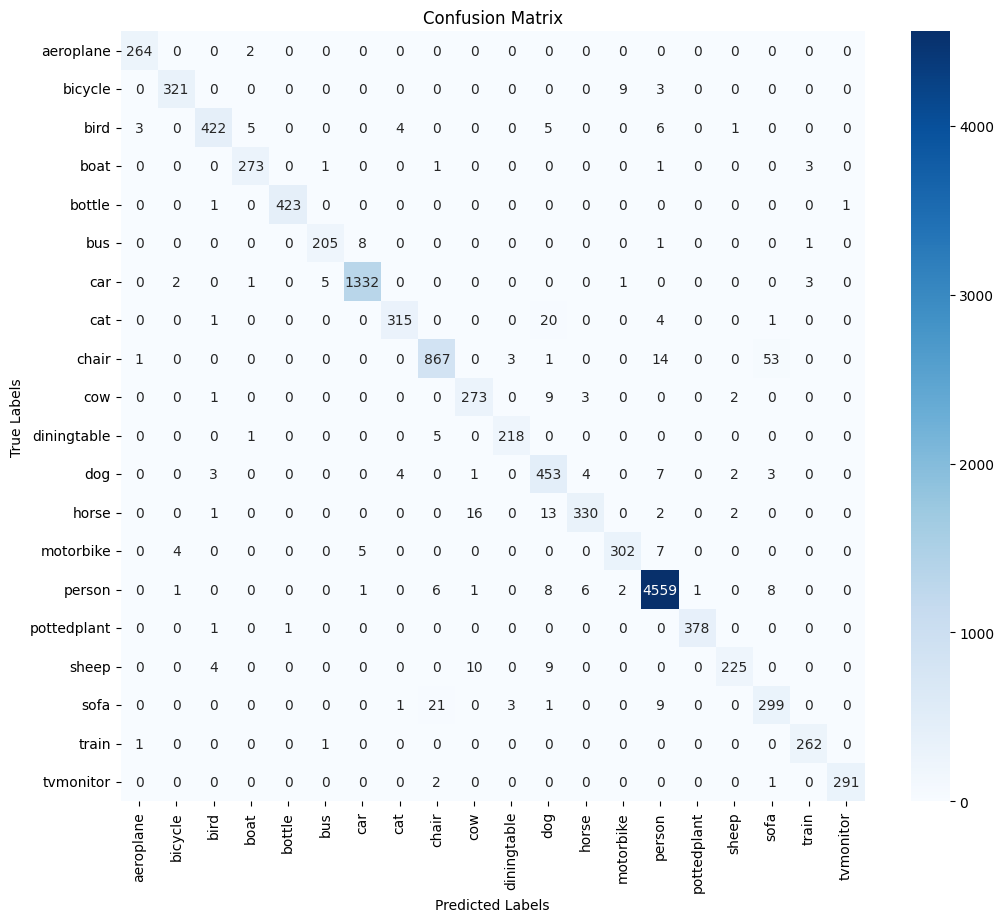

In [ ]:
# Exclude the background class
class_names = VOC_CLASSES[1:]
plot_confusion_matrix(cm, classes=class_names)

##Overall Performance
* Accuracy (97.09%):
** The model correctly classifies nearly 97% of the detected objects. This high accuracy indicates that, overall, the majority of the model's predictions align with the ground truth.
* Precision (96.05%):
** When the model predicts a certain class, about 96% of those predictions are correct. This suggests that false positives are relatively low.
* Recall (95.84%):
** Approximately 96% of all actual instances are correctly identified by the model. This means that it is missing only a small fraction of the objects (low false negatives).
* F1 Score (95.91%):
** The F1 score, which balances precision and recall, is also very high. This confirms that the trade-off between false positives and false negatives is well managed.

##Class-Wise Insights
The classification report provides detailed metrics for each class (ignoring the background). Here are some notable observations:

* High-Performing Classes:
** Aeroplane, Bicycle, Bird, Boat, Bottle, Bus, Car, Cat, Diningtable, Dog, Horse, Motorbike, Person, Pottedplant, Train, TVMonitor
These classes exhibit precision and recall values close to or above 0.95, suggesting that the model is highly reliable when identifying these objects.
* Person Category:
** With 4638 instances and excellent metrics, the "person" category is very well captured by the model. This is particularly important given its high frequency in real-world images.
* Challenges with Specific Classes (e.g., Sofa):
** The "sofa" category shows slightly lower performance (precision = 0.83, recall = 0.88, F1 = 0.85), which might indicate occasional misclassifications. This could be due to visual similarities with other indoor furniture or challenging image conditions like occlusion.

## Confusion Matrix Interpretation
* Diagonal Dominance:
** The highest values in each row lie along the diagonal, which means most objects are classified correctly. For example:
The first row (for aeroplane) has a count of 259 on the diagonal versus only a few misclassifications in off-diagonal cells.
Similarly, most other rows have large diagonal values with relatively small counts off the diagonal.
* Off-Diagonal Entries:
** The presence of non-zero entries off the diagonal indicates some misclassifications. For instance, in the row corresponding to "bicycle", there is a misclassification where some bicycles might have been confused (e.g., 10 instances of another label in one of the cells).
** These off-diagonal counts can provide insights into which classes are more frequently confused—information that can guide future model improvements or data augmentation strategies.

## Summary
* **Robust Performance**:
The high accuracy, precision, recall, and F1 score suggest that the model's classification component is very robust on the Pascal VOC dataset.
* **Areas for Improvement:**
Even though overall performance is excellent, some classes (like sofa) may benefit from additional targeted training or more representative examples to improve classification further.
* **Next Steps:**
To further boost performance, consider:
** More advanced data augmentation.
** Revisiting the annotation strategy or reviewing ambiguous cases as indicated by the confusion matrix.
** Further hyperparameter tuning, especially for classes with slightly lower metrics.

This interpretation shows that the model performs reliably for most object classes, with only a few areas where misclassifications occur. Such insights are valuable for iteratively refining the object detection pipeline.

## 7. Inference: Visualizing Detection Results on a Test Image

### Finally, we visualize the detection results by overlaying bounding boxes and confidence scores on a test image.


In [ ]:
def visualize_detection(image, prediction, threshold=0.5):
    """
    Visualizes bounding boxes and scores on an image.
    """
    image_np = image.permute(1, 2, 0).cpu().numpy()
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image_np)
    boxes = prediction['boxes']
    scores = prediction['scores']
    for box, score in zip(boxes, scores):
        if score >= threshold:
            x1, y1, x2, y2 = box.cpu().detach().numpy()
            rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 fill=False, color='red', linewidth=2)
            ax.add_patch(rect)
            ax.text(x1, y1, f"{score:.2f}", color='yellow', fontsize=12)
    plt.title("Detection Results")
    plt.axis('off')
    plt.show()

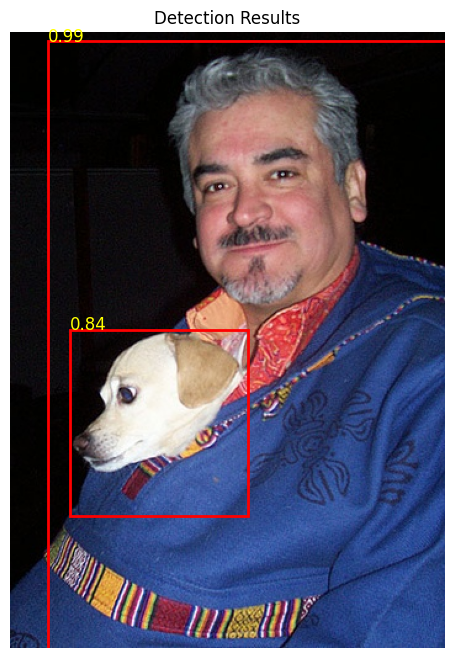

In [ ]:
# Grab one batch of test data and run inference
sample_images, sample_targets = next(iter(test_loader))
sample_images = [img.to(device) for img in sample_images]

with torch.no_grad():
    sample_predictions = model(sample_images)

# Visualize the detection on the first image in the batch
visualize_detection(sample_images[0], sample_predictions[0])